In [ ]:
import importlib, subprocess, sys

def install_if_missing(pkg_name):
    try:
        importlib.import_module(pkg_name)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg_name])

for pkg in ["exifread", "datasets", "huggingface_hub", "pyarrow"]:
    install_if_missing(pkg)

!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
The token `mytoken` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `mytoken`


## Imports

In [ ]:
import os
import exifread, csv
import pyarrow as pa
import pandas as pd

from datasets import load_dataset, Features, Image, Value, Dataset, DownloadConfig
from huggingface_hub import Repository, HfApi
import pyarrow.parquet as pq
import numpy as np
import torch
from torchvision import transforms
from datasets import Image as dsImage

# Importing Image Data and Splitting into Test and Train

In [ ]:
hf_dataset = "myimagetogps/train1"
split_data = "myimagetogps/splitdata"
train_ratio = 0.8
random_seed = 42
local_dir  = "splitdata_repo"
split = "train"
output_csv = "train.csv"

In [ ]:
def get_exif_data(image_path):
    with open(image_path, 'rb') as image_file:
        tags = exifread.process_file(image_file)
    return tags

def export_exif_to_json(exif_data, output_file):
    # Convert tags to a serializable format
    exif_data_serializable = {str(tag): str(value) for tag, value in exif_data.items()}
    with open(output_file, 'w') as json_file:
        json.dump(exif_data_serializable, json_file, indent=4)

# Function to convert GPS coordinates in degrees, minutes, and seconds to decimal degrees
def convert_to_decimal_degrees(value):
    d, m, s = value.values
    return d.num / d.den + (m.num / m.den) / 60 + (s.num / s.den) / 3600

def has_gps(ex):
    """
    Return True if this example’s image has all four GPS tags.
    """
    tags = get_exif_data(ex["image"]["path"])
    return (
        tags.get("GPS GPSLatitude")      is not None and
        tags.get("GPS GPSLatitudeRef")   is not None and
        tags.get("GPS GPSLongitude")     is not None and
        tags.get("GPS GPSLongitudeRef")  is not None
    )


In [ ]:
# Create a DownloadConfig object with a custom timeout
download_config = DownloadConfig(TimeoutError)

# Load the dataset with the custom download configuration
full_ds = load_dataset(
    hf_dataset,
    split=split,
    download_config=download_config,
    features=Features({"image": Image(decode=False)})
).shuffle(seed=random_seed)

# Filter to only those images that actually have GPS tags
filtered_ds = full_ds.filter(has_gps)
print(f"→ {len(filtered_ds)} examples remain after dropping no-GPS images")

# train/test split
n_train  = int(len(filtered_ds) * train_ratio)
train_ds = filtered_ds.select(range(n_train))
test_ds  = filtered_ds.select(range(n_train, len(filtered_ds)))
print(f"→ {len(train_ds)} train / {len(test_ds)} test examples")

Resolving data files:   0%|          | 0/2931 [00:00<?, ?it/s]

IMG_9440.jpeg:   0%|          | 0.00/6.75M [00:00<?, ?B/s]

IMG_9432.jpeg:   0%|          | 0.00/8.42M [00:00<?, ?B/s]

IMG_9442.jpeg:   0%|          | 0.00/6.43M [00:00<?, ?B/s]

IMG_9429.jpeg:   0%|          | 0.00/7.05M [00:00<?, ?B/s]

IMG_9439.jpeg:   0%|          | 0.00/7.79M [00:00<?, ?B/s]

IMG_9435.jpeg:   0%|          | 0.00/9.97M [00:00<?, ?B/s]

IMG_9444.jpeg:   0%|          | 0.00/7.67M [00:00<?, ?B/s]

IMG_9437.jpeg:   0%|          | 0.00/8.45M [00:00<?, ?B/s]

IMG_9431.jpeg:   0%|          | 0.00/6.70M [00:00<?, ?B/s]

IMG_9438.jpeg:   0%|          | 0.00/9.91M [00:00<?, ?B/s]

IMG_9434.jpeg:   0%|          | 0.00/9.79M [00:00<?, ?B/s]

IMG_9441.jpeg:   0%|          | 0.00/5.86M [00:00<?, ?B/s]

IMG_9436.jpeg:   0%|          | 0.00/6.59M [00:00<?, ?B/s]

IMG_9433.jpeg:   0%|          | 0.00/10.1M [00:00<?, ?B/s]

IMG_9430.jpeg:   0%|          | 0.00/6.85M [00:00<?, ?B/s]

IMG_9446.jpeg:   0%|          | 0.00/6.18M [00:00<?, ?B/s]

IMG_9443.jpeg:   0%|          | 0.00/8.45M [00:00<?, ?B/s]

IMG_9445.jpeg:   0%|          | 0.00/7.34M [00:00<?, ?B/s]

IMG_9450.jpeg:   0%|          | 0.00/6.17M [00:00<?, ?B/s]

IMG_9448.jpeg:   0%|          | 0.00/6.81M [00:00<?, ?B/s]

IMG_9451.jpeg:   0%|          | 0.00/6.29M [00:00<?, ?B/s]

IMG_9457.jpeg:   0%|          | 0.00/7.63M [00:00<?, ?B/s]

IMG_9447.jpeg:   0%|          | 0.00/5.87M [00:00<?, ?B/s]

IMG_9452.jpeg:   0%|          | 0.00/7.65M [00:00<?, ?B/s]

IMG_9459.jpeg:   0%|          | 0.00/5.89M [00:00<?, ?B/s]

IMG_9453.jpeg:   0%|          | 0.00/4.89M [00:00<?, ?B/s]

IMG_9454.jpeg:   0%|          | 0.00/4.99M [00:00<?, ?B/s]

IMG_9449.jpeg:   0%|          | 0.00/7.41M [00:00<?, ?B/s]

IMG_9456.jpeg:   0%|          | 0.00/7.17M [00:00<?, ?B/s]

IMG_9458.jpeg:   0%|          | 0.00/6.52M [00:00<?, ?B/s]

IMG_9455.jpeg:   0%|          | 0.00/6.91M [00:00<?, ?B/s]

IMG_9463.jpeg:   0%|          | 0.00/6.60M [00:00<?, ?B/s]

IMG_9460.jpeg:   0%|          | 0.00/5.90M [00:00<?, ?B/s]

IMG_9462.jpeg:   0%|          | 0.00/5.54M [00:00<?, ?B/s]

IMG_9461.jpeg:   0%|          | 0.00/5.09M [00:00<?, ?B/s]

IMG_9464.jpeg:   0%|          | 0.00/7.41M [00:00<?, ?B/s]

IMG_9467.jpeg:   0%|          | 0.00/7.80M [00:00<?, ?B/s]

IMG_9470.jpeg:   0%|          | 0.00/5.70M [00:00<?, ?B/s]

IMG_9466.jpeg:   0%|          | 0.00/6.50M [00:00<?, ?B/s]

IMG_9468.jpeg:   0%|          | 0.00/7.19M [00:00<?, ?B/s]

IMG_9472.jpeg:   0%|          | 0.00/6.71M [00:00<?, ?B/s]

IMG_9471.jpeg:   0%|          | 0.00/5.54M [00:00<?, ?B/s]

IMG_9465.jpeg:   0%|          | 0.00/7.52M [00:00<?, ?B/s]

IMG_9475.jpeg:   0%|          | 0.00/6.59M [00:00<?, ?B/s]

IMG_9469.jpeg:   0%|          | 0.00/5.68M [00:00<?, ?B/s]

IMG_9474.jpeg:   0%|          | 0.00/8.31M [00:00<?, ?B/s]

IMG_9476.jpeg:   0%|          | 0.00/7.00M [00:00<?, ?B/s]

IMG_9478.jpeg:   0%|          | 0.00/5.79M [00:00<?, ?B/s]

IMG_9473.jpeg:   0%|          | 0.00/7.06M [00:00<?, ?B/s]

IMG_9477.jpeg:   0%|          | 0.00/6.48M [00:00<?, ?B/s]

IMG_9482.jpeg:   0%|          | 0.00/7.90M [00:00<?, ?B/s]

IMG_9480.jpeg:   0%|          | 0.00/6.42M [00:00<?, ?B/s]

IMG_9483.jpeg:   0%|          | 0.00/9.34M [00:00<?, ?B/s]

IMG_9481.jpeg:   0%|          | 0.00/7.41M [00:00<?, ?B/s]

IMG_9479.jpeg:   0%|          | 0.00/6.83M [00:00<?, ?B/s]

IMG_9489.jpeg:   0%|          | 0.00/7.30M [00:00<?, ?B/s]

IMG_9487.jpeg:   0%|          | 0.00/6.46M [00:00<?, ?B/s]

IMG_9486.jpeg:   0%|          | 0.00/6.53M [00:00<?, ?B/s]

IMG_9484.jpeg:   0%|          | 0.00/7.45M [00:00<?, ?B/s]

IMG_9485.jpeg:   0%|          | 0.00/8.09M [00:00<?, ?B/s]

IMG_9488.jpeg:   0%|          | 0.00/6.78M [00:00<?, ?B/s]

IMG_9491.jpeg:   0%|          | 0.00/8.39M [00:00<?, ?B/s]

IMG_9490.jpeg:   0%|          | 0.00/8.18M [00:00<?, ?B/s]

IMG_9492.jpeg:   0%|          | 0.00/9.48M [00:00<?, ?B/s]

IMG_9493.jpeg:   0%|          | 0.00/6.96M [00:00<?, ?B/s]

IMG_9494.jpeg:   0%|          | 0.00/6.95M [00:00<?, ?B/s]

IMG_9503.jpeg:   0%|          | 0.00/6.05M [00:00<?, ?B/s]

IMG_9497.jpeg:   0%|          | 0.00/7.33M [00:00<?, ?B/s]

IMG_9495.jpeg:   0%|          | 0.00/7.24M [00:00<?, ?B/s]

IMG_9496.jpeg:   0%|          | 0.00/7.60M [00:00<?, ?B/s]

IMG_9498.jpeg:   0%|          | 0.00/7.34M [00:00<?, ?B/s]

IMG_9505.jpeg:   0%|          | 0.00/6.69M [00:00<?, ?B/s]

IMG_9502.jpeg:   0%|          | 0.00/7.44M [00:00<?, ?B/s]

IMG_9504.jpeg:   0%|          | 0.00/6.79M [00:00<?, ?B/s]

IMG_9500.jpeg:   0%|          | 0.00/8.56M [00:00<?, ?B/s]

IMG_9507.jpeg:   0%|          | 0.00/6.04M [00:00<?, ?B/s]

IMG_9501.jpeg:   0%|          | 0.00/8.26M [00:00<?, ?B/s]

IMG_9506.jpeg:   0%|          | 0.00/8.31M [00:00<?, ?B/s]

IMG_9508.jpeg:   0%|          | 0.00/6.02M [00:00<?, ?B/s]

IMG_9499.jpeg:   0%|          | 0.00/6.17M [00:00<?, ?B/s]

IMG_9513.jpeg:   0%|          | 0.00/7.48M [00:00<?, ?B/s]

IMG_9514.jpeg:   0%|          | 0.00/8.66M [00:00<?, ?B/s]

IMG_9511.jpeg:   0%|          | 0.00/7.17M [00:00<?, ?B/s]

IMG_9520.jpeg:   0%|          | 0.00/7.43M [00:00<?, ?B/s]

IMG_9509.jpeg:   0%|          | 0.00/8.48M [00:00<?, ?B/s]

IMG_9524.jpeg:   0%|          | 0.00/6.92M [00:00<?, ?B/s]

IMG_9515.jpeg:   0%|          | 0.00/8.02M [00:00<?, ?B/s]

IMG_9516.jpeg:   0%|          | 0.00/6.62M [00:00<?, ?B/s]

IMG_9521.jpeg:   0%|          | 0.00/8.73M [00:00<?, ?B/s]

IMG_9512.jpeg:   0%|          | 0.00/7.45M [00:00<?, ?B/s]

IMG_9518.jpeg:   0%|          | 0.00/8.72M [00:00<?, ?B/s]

IMG_9519.jpeg:   0%|          | 0.00/8.38M [00:00<?, ?B/s]

IMG_9523.jpeg:   0%|          | 0.00/6.96M [00:00<?, ?B/s]

IMG_9517.jpeg:   0%|          | 0.00/6.74M [00:00<?, ?B/s]

IMG_9522.jpeg:   0%|          | 0.00/9.02M [00:00<?, ?B/s]

IMG_9510.jpeg:   0%|          | 0.00/8.67M [00:00<?, ?B/s]

IMG_9525.jpeg:   0%|          | 0.00/7.08M [00:00<?, ?B/s]

IMG_9528.jpeg:   0%|          | 0.00/7.49M [00:00<?, ?B/s]

IMG_9527.jpeg:   0%|          | 0.00/8.01M [00:00<?, ?B/s]

IMG_9526.jpeg:   0%|          | 0.00/7.91M [00:00<?, ?B/s]

IMG_9531.jpeg:   0%|          | 0.00/9.00M [00:00<?, ?B/s]

IMG_9530.jpeg:   0%|          | 0.00/8.56M [00:00<?, ?B/s]

IMG_9533.jpeg:   0%|          | 0.00/7.02M [00:00<?, ?B/s]

IMG_9529.jpeg:   0%|          | 0.00/7.34M [00:00<?, ?B/s]

IMG_9532.jpeg:   0%|          | 0.00/6.95M [00:00<?, ?B/s]

IMG_9538.jpeg:   0%|          | 0.00/7.64M [00:00<?, ?B/s]

IMG_9539.jpeg:   0%|          | 0.00/6.96M [00:00<?, ?B/s]

IMG_9537.jpeg:   0%|          | 0.00/7.67M [00:00<?, ?B/s]

IMG_9540.jpeg:   0%|          | 0.00/6.78M [00:00<?, ?B/s]

IMG_9534.jpeg:   0%|          | 0.00/7.42M [00:00<?, ?B/s]

IMG_9536.jpeg:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

IMG_9541.jpeg:   0%|          | 0.00/6.79M [00:00<?, ?B/s]

IMG_9542.jpeg:   0%|          | 0.00/8.02M [00:00<?, ?B/s]

IMG_9543.jpeg:   0%|          | 0.00/8.54M [00:00<?, ?B/s]

IMG_9546.jpeg:   0%|          | 0.00/7.30M [00:00<?, ?B/s]

IMG_9544.jpeg:   0%|          | 0.00/8.14M [00:00<?, ?B/s]

IMG_9545.jpeg:   0%|          | 0.00/8.20M [00:00<?, ?B/s]

IMG_9551.jpeg:   0%|          | 0.00/6.12M [00:00<?, ?B/s]

IMG_9548.jpeg:   0%|          | 0.00/6.53M [00:00<?, ?B/s]

IMG_9550.jpeg:   0%|          | 0.00/5.17M [00:00<?, ?B/s]

IMG_9555.jpeg:   0%|          | 0.00/6.81M [00:00<?, ?B/s]

IMG_9554.jpeg:   0%|          | 0.00/7.65M [00:00<?, ?B/s]

IMG_9549.jpeg:   0%|          | 0.00/5.95M [00:00<?, ?B/s]

IMG_9553.jpeg:   0%|          | 0.00/7.70M [00:00<?, ?B/s]

IMG_9547.jpeg:   0%|          | 0.00/6.73M [00:00<?, ?B/s]

IMG_9552.jpeg:   0%|          | 0.00/7.14M [00:00<?, ?B/s]

IMG_9556.jpeg:   0%|          | 0.00/7.74M [00:00<?, ?B/s]

IMG_9557.jpeg:   0%|          | 0.00/6.73M [00:00<?, ?B/s]

IMG_9535.jpeg:   0%|          | 0.00/7.02M [00:00<?, ?B/s]

IMG_9558.jpeg:   0%|          | 0.00/5.47M [00:00<?, ?B/s]

IMG_9560.jpeg:   0%|          | 0.00/6.90M [00:00<?, ?B/s]

IMG_9561.jpeg:   0%|          | 0.00/8.32M [00:00<?, ?B/s]

IMG_9566.jpeg:   0%|          | 0.00/8.81M [00:00<?, ?B/s]

IMG_9564.jpeg:   0%|          | 0.00/7.25M [00:00<?, ?B/s]

IMG_9563.jpeg:   0%|          | 0.00/7.62M [00:00<?, ?B/s]

IMG_9565.jpeg:   0%|          | 0.00/7.88M [00:00<?, ?B/s]

IMG_9567.jpeg:   0%|          | 0.00/7.08M [00:00<?, ?B/s]

IMG_9562.jpeg:   0%|          | 0.00/8.40M [00:00<?, ?B/s]

IMG_9569.jpeg:   0%|          | 0.00/5.82M [00:00<?, ?B/s]

IMG_9570.jpeg:   0%|          | 0.00/6.29M [00:00<?, ?B/s]

IMG_9571.jpeg:   0%|          | 0.00/7.05M [00:00<?, ?B/s]

IMG_9568.jpeg:   0%|          | 0.00/5.25M [00:00<?, ?B/s]

IMG_9574.jpeg:   0%|          | 0.00/8.35M [00:00<?, ?B/s]

IMG_9575.jpeg:   0%|          | 0.00/9.26M [00:00<?, ?B/s]

IMG_9572.jpeg:   0%|          | 0.00/8.23M [00:00<?, ?B/s]

IMG_9573.jpeg:   0%|          | 0.00/8.02M [00:00<?, ?B/s]

IMG_9559.jpeg:   0%|          | 0.00/6.32M [00:00<?, ?B/s]

IMG_9576.jpeg:   0%|          | 0.00/8.03M [00:00<?, ?B/s]

IMG_9579.jpeg:   0%|          | 0.00/6.09M [00:00<?, ?B/s]

IMG_9578.jpeg:   0%|          | 0.00/6.39M [00:00<?, ?B/s]

IMG_9580.jpeg:   0%|          | 0.00/6.27M [00:00<?, ?B/s]

IMG_9583.jpeg:   0%|          | 0.00/7.55M [00:00<?, ?B/s]

IMG_9581.jpeg:   0%|          | 0.00/5.81M [00:00<?, ?B/s]

IMG_9582.jpeg:   0%|          | 0.00/7.49M [00:00<?, ?B/s]

IMG_9584.jpeg:   0%|          | 0.00/8.15M [00:00<?, ?B/s]

IMG_9577.jpeg:   0%|          | 0.00/7.01M [00:00<?, ?B/s]

IMG_9586.jpeg:   0%|          | 0.00/8.01M [00:00<?, ?B/s]

IMG_9585.jpeg:   0%|          | 0.00/8.28M [00:00<?, ?B/s]

IMG_9589.jpeg:   0%|          | 0.00/6.29M [00:00<?, ?B/s]

IMG_9588.jpeg:   0%|          | 0.00/7.49M [00:00<?, ?B/s]

IMG_9587.jpeg:   0%|          | 0.00/7.81M [00:00<?, ?B/s]

IMG_9592.jpeg:   0%|          | 0.00/6.59M [00:00<?, ?B/s]

IMG_9591.jpeg:   0%|          | 0.00/5.74M [00:00<?, ?B/s]

IMG_9590.jpeg:   0%|          | 0.00/5.35M [00:00<?, ?B/s]

IMG_9594.jpeg:   0%|          | 0.00/8.76M [00:00<?, ?B/s]

IMG_9593.jpeg:   0%|          | 0.00/8.05M [00:00<?, ?B/s]

IMG_9595.jpeg:   0%|          | 0.00/10.0M [00:00<?, ?B/s]

IMG_9596.jpeg:   0%|          | 0.00/7.90M [00:00<?, ?B/s]

IMG_9597.jpeg:   0%|          | 0.00/5.27M [00:00<?, ?B/s]

IMG_9600.jpeg:   0%|          | 0.00/7.63M [00:00<?, ?B/s]

IMG_9598.jpeg:   0%|          | 0.00/6.04M [00:00<?, ?B/s]

IMG_9599.jpeg:   0%|          | 0.00/6.77M [00:00<?, ?B/s]

IMG_9602.jpeg:   0%|          | 0.00/7.45M [00:00<?, ?B/s]

IMG_9601.jpeg:   0%|          | 0.00/7.71M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Filter:   0%|          | 0/2931 [00:00<?, ? examples/s]

→ 2051 examples remain after dropping no-GPS images
→ 1640 train / 411 test examples


In [ ]:
# Clone splitdata repo to local_dir
repo = Repository(
    local_dir=local_dir,
    clone_from=split_data,
    repo_type="dataset",
    token=True
)

# Making sure Train/ and Test/ folders exist locally
train_folder = os.path.join(local_dir, "Train")
test_folder  = os.path.join(local_dir, "Test")
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder,  exist_ok=True)

# Define the Parquet schema: embed raw image bytes + location
parquet_features = Features({
    "image": dsImage(),              # raw-bytes
    "Latitude": Value("float32"),
    "Longitude": Value("float32"),
})

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
/content/splitdata_repo is already a clone of https://huggingface.co/datasets/myimagetogps/splitdata. Make sure you pull the latest changes with `repo.git_pull()`.


In [ ]:
# Function to build & write one Parquet shard
def build_and_save_parquet_streaming(name, ds, out_folder):
    out_path     = os.path.join(out_folder, f"{name}_data.parquet")
    arrow_schema = parquet_features.arrow_schema   # existing schema
    writer       = pq.ParquetWriter(out_path, schema=arrow_schema)

    for ex in ds:
        path    = ex["image"]["path"]
        fname   = os.path.basename(path)

        tags    = get_exif_data(path)
        lat_tag = tags.get("GPS GPSLatitude")
        lat_ref = tags.get("GPS GPSLatitudeRef")
        lon_tag = tags.get("GPS GPSLongitude")
        lon_ref = tags.get("GPS GPSLongitudeRef")

        if lat_tag and lat_ref and lon_tag and lon_ref:
            lat = convert_to_decimal_degrees(lat_tag)
            if lat_ref.values[0] == "S": lat = -lat
            lon = convert_to_decimal_degrees(lon_tag)
            if lon_ref.values[0] == "W": lon = -lon
        else:
            lat, lon = None, None

        # read raw bytes
        with open(path, "rb") as f:
            img_bytes = f.read()

        row = {
            "image":    {"path": fname, "bytes": img_bytes},
            "Latitude": lat,
            "Longitude": lon
        }

        batch = pa.Table.from_pylist([row], schema=arrow_schema)
        writer.write_table(batch)

    writer.close()
    print(f"✔ {name}: wrote streaming Parquet to {out_path}")

In [ ]:
# Build & save for both splits
build_and_save_parquet_streaming("train", train_ds, train_folder)
build_and_save_parquet_streaming("test",  test_ds,  test_folder)

# Push the updated splitdata repo back up
repo.push_to_hub(commit_message="Add train_data.parquet & test_data.parquet with images+GPS")

print("🚀 Done! Splitdata dataset now has:")
print(f"   {split_data}/Train/train_data.parquet")
print(f"   {split_data}/Test/test_data.parquet")

✔ train: wrote streaming Parquet to splitdata_repo/Train/train_data.parquet
✔ test: wrote streaming Parquet to splitdata_repo/Test/test_data.parquet


Upload file Train/train_data.parquet:   0%|          | 1.00/6.52G [00:00<?, ?B/s]

Upload file Test/test_data.parquet:   0%|          | 1.00/1.65G [00:00<?, ?B/s]

To https://huggingface.co/datasets/myimagetogps/splitdata
   ee8596e..0188af6  main -> main

   ee8596e..0188af6  main -> main



🚀 Done! Your splitdata dataset now has:
   myimagetogps/splitdata/Train/train_data.parquet
   myimagetogps/splitdata/Test/test_data.parquet


# RESIZING THE IMAGES

In [ ]:
# (Re)load your Parquet splits from HF, if needed
# Comment out if you already have train_ds / test_ds in memory:
train_ds = load_dataset("myimagetogps/splitdata", split="train")
test_ds  = load_dataset("myimagetogps/splitdata", split="test")

# Compute GPS mean/std on the train split

lat_arr = np.array(train_ds["Latitude"], dtype=float)
lon_arr = np.array(train_ds["Longitude"], dtype=float)
lat_mean, lat_std = lat_arr.mean(), lat_arr.std()
lon_mean, lon_std = lon_arr.mean(), lon_arr.std()

print(f"GPS means → lat: {lat_mean:.5f}, lon: {lon_mean:.5f}")
print(f"GPS stds  → lat: {lat_std:.5f}, lon: {lon_std:.5f}")

# Define a simple resize + ToTensor + normalize transform

img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


GPS means → lat: 39.95206, lon: -75.19159
GPS stds  → lat: 0.00062, lon: 0.00076


In [ ]:
# Helper to denormalize a torch.Tensor for plotting
def denormalize(img_t: torch.Tensor, mean, std):
    """Undo torchvision Normalize and convert to H×W×C numpy in [0,1]."""
    m = torch.tensor(mean).view(3,1,1)
    s = torch.tensor(std).view(3,1,1)
    img = img_t * s + m
    arr = img.clamp(0,1).permute(1,2,0).cpu().numpy()
    return arr

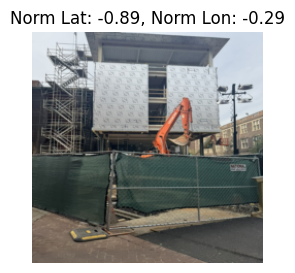

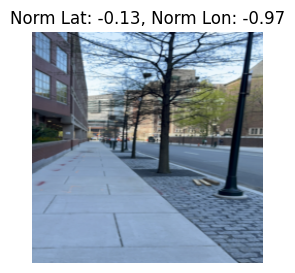

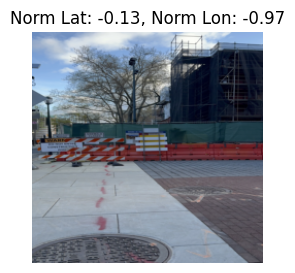

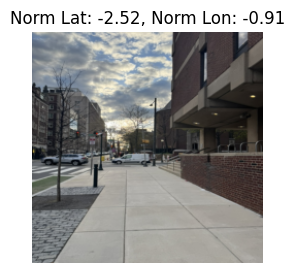

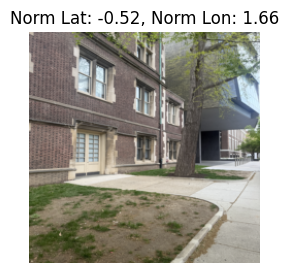

In [ ]:
# Ploting five examples with their normalized GPS coords
import matplotlib.pyplot as plt

for i in range(5):
    ex = train_ds[i]
    img = ex["image"]            # PIL.Image
    lat = (ex["Latitude"]  - lat_mean) / lat_std
    lon = (ex["Longitude"] - lon_mean) / lon_std

    # transform & denormalize for display
    timg = img_transform(img)
    arr  = denormalize(timg, [0.485,0.456,0.406], [0.229,0.224,0.225])

    plt.figure(figsize=(3,3))
    plt.imshow(arr)
    plt.title(f"Norm Lat: {lat:.2f}, Norm Lon: {lon:.2f}")
    plt.axis("off")
    plt.show()